<a href="https://colab.research.google.com/github/Sottix99/ADM-HW5/blob/main/2_1%2Berica_functionality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data

### Data Preprocessing

In [1]:
import pandas as pd
import networkx as nx
import string
import numpy as np
import scipy
from collections import Counter
from tabulate import tabulate
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
edges = pd.read_csv('/content/drive/MyDrive/hw 5 ADM/edges.csv')

In [4]:
hero_network = pd.read_csv('/content/drive/MyDrive/hw 5 ADM/hero-network.csv')

In [5]:
nodes = pd.read_csv('/content/drive/MyDrive/hw 5 ADM/nodes.csv')

Removing inconsistencies

In [6]:
#Removing extra spaces at the end of the hero name
hero_network['hero1'] = hero_network['hero1'].apply(lambda x: x.rstrip())
hero_network['hero2'] = hero_network['hero2'].apply(lambda x: x.rstrip())

In [7]:
#Replace 'SPIDER-MAN/PETER PAR' with 'SPIDER-MAN/PETER PARKER'
hero_network.replace({'SPIDER-MAN/PETER PAR': 'SPIDER-MAN/PETER PARKER'}, inplace = True)

In [8]:
#Removing extra '/'
hero_network['hero1'] = hero_network['hero1'].apply(lambda x: x.rstrip('/'))
hero_network['hero2'] = hero_network['hero2'].apply(lambda x: x.rstrip('/'))
edges['hero'] = edges['hero'].apply(lambda x: x.strip('/'))

In [9]:
#After this we need to remove again the empty spaces at the end
hero_network['hero1'] = hero_network['hero1'].apply(lambda x: x.rstrip())
hero_network['hero2'] = hero_network['hero2'].apply(lambda x: x.rstrip())
edges['hero'] = edges['hero'].apply(lambda x: x.rstrip())

Removing duplicates

Let's remove rows where hero1 is equal to hero2 first.

In [10]:
hero_network.drop((hero_network[hero_network['hero1'] == hero_network['hero2']]).index, inplace = True)

Sortiamo i nomi per riga così da non avere problemi nel calcolo delle collaborazioni e dei pesi

In [11]:
hero_network = hero_network.apply(lambda row: sorted(row), axis=1, result_type='expand').set_axis(hero_network.columns, axis=1)


### Graphs setup

##### First graph

In [12]:
hero_network.groupby(['hero1', 'hero2']).size()


hero1                 hero2               
24-HOUR MAN/EMMANUEL  FROST, CARMILLA         1
                      G'RATH                  1
                      KILLRAVEN/JONATHAN R    1
                      M'SHULLA                1
                      OLD SKULL               1
                                             ..
ZEFRA                 ZON                     1
ZEUS                  ZIRAN                   1
                      ZURAS                   4
ZIRAN                 ZON                     1
                      ZURAS                   1
Length: 167100, dtype: int64

In [13]:
hero_network = hero_network.groupby(['hero1', 'hero2']).size().reset_index().rename(columns={0: 'size'})

In [14]:
hero_network

,hero1,hero2,size
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1
1,24-HOUR MAN/EMMANUEL,G'RATH,1
2,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1
3,24-HOUR MAN/EMMANUEL,M'SHULLA,1
4,24-HOUR MAN/EMMANUEL,OLD SKULL,1
...,...,...,...
167095,ZEFRA,ZON,1
167096,ZEUS,ZIRAN,1
167097,ZEUS,ZURAS,4
167098,ZIRAN,ZON,1


In [15]:
G_hero_net = nx.Graph()

We want the graph to be weighted and we also want the weight to be lower for heroes with more collaborations, hence we take as weights the reciprocal number of the number of collaboration (the size)

In [16]:
# creating a list of 3d tuples where the first two elements are the nodes and the last is the weight
edges_l = []
hero_network.apply(lambda row : edges_l.append((row['hero1'], row['hero2'], 1/row['size'])), axis = 1)

# creating the weighted graph
G_hero_net.add_weighted_edges_from(edges_l)


In [17]:
nx.info(G_hero_net)

<ipython-input-17-9aae3d13bf13>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_hero_net)


'Graph with 6421 nodes and 167100 edges'

##### Second graph

In [18]:
G_comic_net = nx.Graph()

In [19]:
G_comic_net.add_nodes_from(list(nodes['node']))

edges_list= []
edges.apply(lambda row: edges_list.append((row['hero'], row['comic'])), axis = 1)

G_comic_net.add_edges_from(edges_list)

Then we create two different list that contains only the name of heroes or comics

In [20]:
n_h=nodes[nodes['type'] == 'hero']['node'].tolist()

In [21]:
n_c=nodes[nodes['type'] == 'comic']['node'].tolist()

Now we merge the two lists in a dictionary 

In [22]:
dict_heroes_comics = {key: 'hero' if key in n_h else 'comic' for key in n_c + n_h}

Finally we add at each node of the graph its type

In [23]:
nx.set_node_attributes(G_comic_net, dict_heroes_comics, 'type')

In [24]:
nx.info(G_comic_net)

<ipython-input-24-e46de23b8851>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_comic_net)


'Graph with 19519 nodes and 96104 edges'

# Backend Implementation & Frontend Implementation

## Functionality 1 - extract the graph's features

In [ ]:
all_heroes=len(edges['hero'].value_counts())
all_heroes

6439

we save that value because it will be used in the functions to create the subgraph

In [ ]:
def create_subN1(G,N):
  if N == all_heroes: # if N is not set by the user, the function should consider the whole data
    sub_g=G
  else: # otherwise we select only the top n nodes 
    series=edges['hero'].value_counts()[0:N]
    names_list=series.index.tolist()
    sub_g=G.subgraph(names_list)
  return sub_g

The difference between subN1 and subN2 is that in the latter one we consider also all the comic nodes, otherwise the graph will be empty (the edges are only  between a hero and a comic)

In [ ]:
def create_subN2(G,N):
  if N == all_heroes: # if N is not set by the user, the function should consider the whole data
    sub_g=G
  else: # otherwise we select only the top n nodes of heroes + all comics
    series=edges['hero'].value_counts()[0:N]
    names_list=series.index.tolist()
    comics_list=edges['comic'].value_counts().index.tolist()
    all=names_list+comics_list
    sub_g=G.subgraph(all)
  return sub_g

In [ ]:
def functional1_type1(sub_g, G_type):

   output={} # initialize the dict of outputs

   # The number of nodes in the network
   num_nodes = sub_g.number_of_nodes()
   output['Number of nodes']=num_nodes

   # The number of collaborations of each superhero with the others (i.e the degrees)
   degrees=dict(sub_g.degree())
   output['Collaborations']=list(degrees.items())
  
   # The network's density
   density = nx.density(sub_g)
   output['Density']=density

   # The average degree of the network
   avg_degree=sum(degrees.values())/len(degrees.values())
   output['Average Degree']=avg_degree

   # The network's degree distribution
   degrees_list=list(degrees.values())
   degree_distribution = Counter(degrees_list) # Given the degrees list we obatin the frequency distribution
   sorted_degree_distribution = sorted(degree_distribution.items(), key=lambda x: x[0]) # we sort the frequency by the keys
   output['Degree Distribution']=sorted_degree_distribution





   # The network's Hubs
   sorted_dict = sorted(degrees.items(), key=lambda x: x[1])
   pos=int(len(sorted_dict)*0.95)
   output['Network Hubs']=sorted_dict[pos-1::]

   # Whether the Network is sparse or dense
   if density>0.5:
    output['Dense']=1.0 # 1 if it is dense
   else:
    output['Dense']=0.0 # 0 if it is sparse

   return output 


In [ ]:
G_comic_net.number_of_nodes()

19519

In [ ]:
def functional1_type2(sub_g, G_type):

   output={} # initialize the dict of outputs

# The following 3 rows of code will be usefull for the functionals regarding only the comic nodes

   # we obtain for each node the type
   dictionary_types=dict(nx.get_node_attributes(sub_g, "type"))
   # Then we obtain the list with only the comic nodes
   keys_comic = {k: v for k, v in dictionary_types.items() if v == 'comic'}
   comics=list(keys_comic.keys())

# Now we can start:

# regarding the Density of the graph we will use both types of nodes

   # The network's density
   density = nx.density(sub_g)
   output['Density']=density

   # Whether the Network is sparse or dense
   if density>0.5:
    output['Dense']=1.0 # 1 if it is dense
   else:
    output['Dense']=0.0 # 0 if it is sparse

# regarding the other operations we will consider only the comic type:

   # The number of nodes for both types
   total_number= sub_g.number_of_nodes()

   degrees=dict(sub_g.degree())
   comics_subset = {k: v for k, v in degrees.items() if k in comics}
   heroes_subset = {k: v for k, v in degrees.items() if k not in comics} 

   output['Total number of nodes']=total_number

   output['Number of heroes']=len(list(heroes_subset.items()))

   output['Number of comics']=len(list(comics_subset.items()))

   # The number of heroes that have appeared in each comic (i.e the degrees)
   degrees_subset = {k: v for k, v in degrees.items() if k in comics}
   output['Number of heroes in the comic']=list(degrees_subset.items())

   # The network's degree distribution
   degrees_list=list(degrees_subset.values())
   degree_distribution = Counter(degrees_list) # Given the degrees list we obatin the frequency distribution
   sorted_degree_distribution = sorted(degree_distribution.items(), key=lambda x: x[0]) # we sort the frequency by the keys
   output['Degree Distribution']=sorted_degree_distribution # The output means how many times each degree appears

   # The average degree of the network
   avg_degree=sum(degrees_subset.values())/len(degrees_subset.values())
   output['Average Degree']=avg_degree

   # The network's Hubs
   sorted_dict = sorted(degrees_subset.items(), key=lambda x: x[1])
   pos=int(len(sorted_dict)*0.95)
   output['Network Hubs']=sorted_dict[pos-1::]

   return output


In [ ]:
def ex_features(G, G_type, N = all_heroes):
  
#################### Neither 1 or 2 ########################################
  
  if G_type not in [1, 2]:
    raise ValueError('Invalid graph type: remember, this function only accepts graph types equal to 1 or 2')

#################### TYPE = 1 ##############################################

  elif G_type == 1:
   # Create the Sub 
   sub_g= create_subN1(G,N)
   
   # Apply all the functions for Type = 1
   output= functional1_type1(sub_g, G_type)

   
#################### TYPE = 2 ##############################################

  else: 
   # Create the Sub  
   sub_g= create_subN2(G,N)
  
   # Apply all the functions for Type = 2
   output= functional1_type2(sub_g, G_type)


  return output

In [ ]:
ex_features(G_hero_net, 1, 10)

{'Number of nodes': 10,
 'Collaborations': [('HULK/DR. ROBERT BRUC', 9),
  ('CAPTAIN AMERICA', 9),
  ('THOR/DR. DONALD BLAK', 9),
  ('MR. FANTASTIC/REED R', 9),
  ('HUMAN TORCH/JOHNNY S', 9),
  ('IRON MAN/TONY STARK', 9),
  ('THING/BENJAMIN J. GR', 9),
  ('INVISIBLE WOMAN/SUE', 9),
  ('SPIDER-MAN/PETER PARKER', 9),
  ('WOLVERINE/LOGAN', 9)],
 'Density': 1.0,
 'Average Degree': 9.0,
 'Degree Distribution': [(9, 10)],
 'Network Hubs': [('SPIDER-MAN/PETER PARKER', 9), ('WOLVERINE/LOGAN', 9)],
 'Dense': 1.0}

In [ ]:
ex_features(G_comic_net, 2, 10)

## Visualization 1 - Visualize some features of the network

In [ ]:
example1=ex_features(G_hero_net, 1, 50)

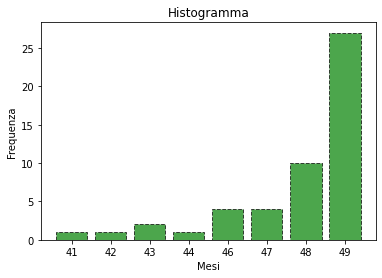

In [ ]:
adict=dict(example1['Degree Distribution'])
val=list(adict.values())
keys=list(adict.keys())
plt.bar(range(len(val)), val, color='g', linestyle='dashed', edgecolor='k', alpha=0.7, label='Esempio')
plt.title('Histogramma')
plt.xlabel('Mesi')
plt.ylabel('Frequenza')

# Imposta le label per l'asse x
plt.xticks(range(len(keys)),keys)
plt.show()

In [ ]:
table_colab = tabulate(example1['Network Hubs'], headers=["Node", "Degree"], tablefmt="fancy_grid")
print(table_colab)

╒═════════════════════════╤══════════╕
│ Node                    │   Degree │
╞═════════════════════════╪══════════╡
│ VISION                  │       49 │
├─────────────────────────┼──────────┤
│ SHE-HULK/JENNIFER WA    │       49 │
├─────────────────────────┼──────────┤
│ THING/BENJAMIN J. GR    │       49 │
├─────────────────────────┼──────────┤
│ SPIDER-MAN/PETER PARKER │       49 │
╘═════════════════════════╧══════════╛


In [ ]:
type(example1['Collaborations'])

list

In [ ]:
values=[]
values.append(example1['Number of nodes'])
values.append(example1['Density'])
values.append(example1['Average Degree'])
values.append(example1['Dense'])

In [ ]:
table = tabulate([values], headers=["Number of nodes", "Density", "Average degree", "Dense"], tablefmt="fancy_grid")
print(table)

╒═══════════════════╤═══════════╤══════════════════╤═════════╕
│   Number of nodes │   Density │   Average degree │   Dense │
╞═══════════════════╪═══════════╪══════════════════╪═════════╡
│                50 │  0.974694 │            47.76 │       1 │
╘═══════════════════╧═══════════╧══════════════════╧═════════╛


In [ ]:
def visualization1(G, G_type, N):
  example1=ex_features(G, G_type, N)
  values=[]
  if G_type == 1:
   values.append(example1['Number of nodes'])
  else:
   values.append(example1['Total number of nodes'])

  values.append(example1['Density'])
  values.append(example1['Average Degree'])
  values.append(example1['Dense'])
  table = tabulate([values], headers=["Number of nodes", "Density", "Average degree", "Dense"], tablefmt="fancy_grid")
  print('General information about the graph:')
  print(table)
  example1['Network Hubs'].sort(key=lambda x: x[1], reverse=True)
  table_hub = tabulate(example1['Network Hubs'], headers=["Node", "Degree"], tablefmt="fancy_grid")
  print("Network's hubs:")
  print(table_hub)
  
  if G_type == 1:
    example1['Collaborations'].sort(key=lambda x: x[1], reverse=True)
    table_colab = tabulate(example1['Collaborations'], headers=["Hero", "Number of collaborations"], tablefmt="fancy_grid")
    print(table_colab)

  
  adict=dict(example1['Degree Distribution'])
  val=list(adict.values())
  keys=list(adict.keys())
  plt.bar(range(len(val)), val, color='g', linestyle='dashed', edgecolor='k', alpha=0.7, label='Esempio')
  plt.title('Histogram of the degree distribution')
  plt.xlabel('Degree')
  plt.ylabel('Frequency')
  plt.xticks(range(len(keys)),keys)
  plt.show()


General information about the graph:
╒═══════════════════╤═════════════╤══════════════════╤═════════╕
│   Number of nodes │     Density │   Average degree │   Dense │
╞═══════════════════╪═════════════╪══════════════════╪═════════╡
│             12711 │ 0.000375026 │          2.39839 │       0 │
╘═══════════════════╧═════════════╧══════════════════╧═════════╛
Network's hubs:
╒═══════════╤══════════╕
│ Node      │   Degree │
╞═══════════╪══════════╡
│ BLADE     │       43 │
├───────────┼──────────┤
│ H2 279    │       36 │
├───────────┼──────────┤
│ COC 1     │       35 │
├───────────┼──────────┤
│ IW 2      │       32 │
├───────────┼──────────┤
│ IW 3      │       32 │
├───────────┼──────────┤
│ M/GN 1    │       32 │
├───────────┼──────────┤
│ O:MU      │       31 │
├───────────┼──────────┤
│ H2 278    │       30 │
├───────────┼──────────┤
│ IW 4      │       29 │
├───────────┼──────────┤
│ FF 368    │       26 │
├───────────┼──────────┤
│ FF 370    │       26 │
├───────────┼─────────

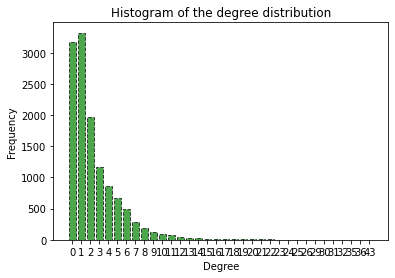

In [ ]:
visualization1(G_comic_net, 2, 60)

## Functionality 2 - Find top superheroes!


In [ ]:
N = 10
topN = edges.groupby('hero').count().sort_values(by = 'comic', ascending = False).head(N)
topN = topN.reset_index()
topN

,hero,comic
0,SPIDER-MAN/PETER PARKER,1577
1,CAPTAIN AMERICA,1334
2,IRON MAN/TONY STARK,1150
3,THING/BENJAMIN J. GR,963
4,THOR/DR. DONALD BLAK,956
5,HUMAN TORCH/JOHNNY S,886
6,MR. FANTASTIC/REED R,854
7,HULK/DR. ROBERT BRUC,835
8,WOLVERINE/LOGAN,819
9,INVISIBLE WOMAN/SUE,762


In [ ]:
def functionality2(G, node, metric, N):
     #trovo i top N 
     topN = edges.groupby('hero').count().sort_values(by = 'comic', ascending = False).head(N)
     topN = topN.reset_index()

     if G == G_hero_net:
          #creo il sottografo
          subG = G.subgraph(list(topN['hero']))

          #calcolo le metriche su tutto il grafo
          if metric == 'Betweeness':
               all_values = nx.betweenness_centrality(subG, weight = 'weight')

          elif metric == 'PageRank':
               all_values = nx.pagerank(subG, weight = 'weight')

          elif metric == 'ClosenessCentrality':
               all_values = nx.closeness_centrality(subG, distance = 'weight')

          elif metric == 'DegreeCentrality':
               all_values = nx.degree_centrality(subG)

          #calcolo le metriche sul nodo passato 
          if node in subG.nodes:
               nvalue = all_values[node]
          else:
               nvalue = 'ERROR: node not in the subgraph'

          return all_values, nvalue

     if G == G_comic_net:
          # creo il sottografo prendendo nel grafo G_comic_net tutti in gli edges collegati agli eroi in topN
          reduced_edges = []
          for n in topN['hero']:
               for elem in G.edges(n):
                    reduced_edges.append(elem)
          subG = nx.Graph()
          subG.add_edges_from(set(reduced_edges))
          
          #calcolo le metriche su tutto il grafo
          if metric == 'Betweeness':
               all_values = nx.betweenness_centrality(subG)

          elif metric == 'PageRank':
               all_values = nx.pagerank(subG)

          elif metric == 'ClosenessCentrality':
               all_values = nx.closeness_centrality(subG)

          elif metric == 'DegreeCentrality':
               all_values = nx.degree_centrality(subG)

          #calcolo le metriche sul nodo passato 
          if node in subG.nodes:
               nvalue = all_values[node]
          else:
               nvalue = 'ERROR: node not in the subgraph'

          return all_values, nvalue

     

## Visualization 2 - Visualize centrality measure

In [ ]:
from tabulate import tabulate

Let's start with plotting the info about the first graph "G_hero_net"

In [ ]:
#calling the function on different metrics to gather all the data 

all_values, n_value = functionality2(G_hero_net, 'CAPTAIN AMERICA', 'Betweeness', 10)

col_names = ["Betweeness Centrality", "PageRank", "Closeness Centrality", "Degree centrality"]
data = [["Average value", np.mean(list(all_values.values()))], ["Node value", n_value]]

all_values, n_value = functionality2(G_hero_net, 'CAPTAIN AMERICA', 'PageRank', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

all_values, n_value = functionality2(G_hero_net, 'CAPTAIN AMERICA', 'ClosenessCentrality', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

all_values, n_value = functionality2(G_hero_net, 'CAPTAIN AMERICA', 'DegreeCentrality', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))
#all_values = pd.DataFrame.from_dict(g, orient ='index', columns = ["metric's value"])


╒═══════════════╤═════════════════════════╤════════════╤════════════════════════╤═════════════════════╕
│               │   Betweeness Centrality │   PageRank │   Closeness Centrality │   Degree centrality │
╞═══════════════╪═════════════════════════╪════════════╪════════════════════════╪═════════════════════╡
│ Average value │               0.0361111 │  0.1       │                126.784 │                   1 │
├───────────────┼─────────────────────────┼────────────┼────────────────────────┼─────────────────────┤
│ Node value    │               0.194444  │  0.0724748 │                153.647 │                   1 │
╘═══════════════╧═════════════════════════╧════════════╧════════════════════════╧═════════════════════╛


About the second graph "G_comic_net":

In [ ]:
#calling the function on different metrics to gather all the data 
all_values, n_value = functionality2(G_comic_net, 'CAPTAIN AMERICA', 'Betweeness', 10)

col_names = ["Betweeness Centrality", "PageRank", "Closeness Centrality", "Degree centrality"]
data = [["Average value", np.mean(list(all_values.values()))], ["Node value", n_value]]

all_values, n_value = functionality2(G_comic_net, 'CAPTAIN AMERICA', 'PageRank', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

all_values, n_value = functionality2(G_comic_net, 'CAPTAIN AMERICA', 'ClosenessCentrality', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

all_values, n_value = functionality2(G_comic_net, 'CAPTAIN AMERICA', 'DegreeCentrality', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════╤═════════════════════════╤═════════════╤════════════════════════╤═════════════════════╕
│               │   Betweeness Centrality │    PageRank │   Closeness Centrality │   Degree centrality │
╞═══════════════╪═════════════════════════╪═════════════╪════════════════════════╪═════════════════════╡
│ Average value │             0.000416292 │ 0.000165044 │               0.2856   │         0.000552289 │
├───────────────┼─────────────────────────┼─────────────┼────────────────────────┼─────────────────────┤
│ Node value    │             0.269249    │ 0.0639633   │               0.390914 │         0.220205    │
╘═══════════════╧═════════════════════════╧═════════════╧════════════════════════╧═════════════════════╛


## Functionality 4 - Disconnecting Graphs

For this functionality we took a cue from the Ford-Fulkerson algorithm 


In [ ]:
def DepthFirstSearch(G, node, visited):
    visited[node] = 1
    for neighbor in G.neighbors(node):
        if visited[neighbor] == 0:
            DepthFirstSearch(G, neighbor, visited)
    return 



def functionality4(G, heroA, heroB, N):
    topN = edges.groupby('hero').count().sort_values(by = 'comic', ascending = False).head(10)
    topN = topN.reset_index()

    if G == G_hero_net:
        subG = G.subgraph(list(topN['hero']))
    elif G == G_comic_net:
        reduced_edges = []
        for n in topN['hero']:
            for elem in G.edges(n):
                reduced_edges.append(elem)
        subG = nx.Graph()
        subG.add_edges_from(set(reduced_edges))

    #dizionario per segnare se ho visitato il nodo durante la ricerca in profondità
    visited = {node: 0 for node in subG.nodes}
    
    #faccio la ricerca in profondità partendo dal nodo heroA
    DepthFirstSearch(subG, heroA, visited)

    #inizializzo un contatore per il numero minimo di tagli
    counter = 0
    # e qui salverò se ho gia contato quell'edge come da tagliare
    marked = []

    # se heroA e heroB sono direttamente collegati segno l'edge come da tagliare e aumento il contatore
    if heroB in subG.neighbors(heroA):
        marked.append((heroA, heroB))
        counter += 1

    # loop su tutti i nodi del sottografo
    for node in subG.nodes:
        if node == heroB:
            continue 
        
        #se il nodo non è stato visitato vuol dire che non è collegato a heroA e lo salto
        if visited[node] == 0:
            continue
        
        # in tutti gli altri casi scorro i vicini del nodo
        for n in subG.neighbors(node):
            # se un vicino del nodo è anche vicino di heroB
            if n in subG.neighbors(heroB) and n!=heroB:
                # se non sono già passata per quell'edge
                if ((n, heroB) not in marked):
                    # segno l'edge come da tagliare e aumento il contatore
                    marked.append((n, heroB))
                    counter += 1
    
    return counter, marked, subG

## Visualization 4 - Visualize the disconnected graph

Testing on the first graph

In [ ]:
heroA = 'CAPTAIN AMERICA'
heroB = 'WOLVERINE/LOGAN'
N = 10
min_num, min_edges, subG = functionality4(G_hero_net, heroA, heroB, N)

In [ ]:
print('The minimum number of links that should be disconnected is', min_num)

The minimum number of links that should be disconnected is 9


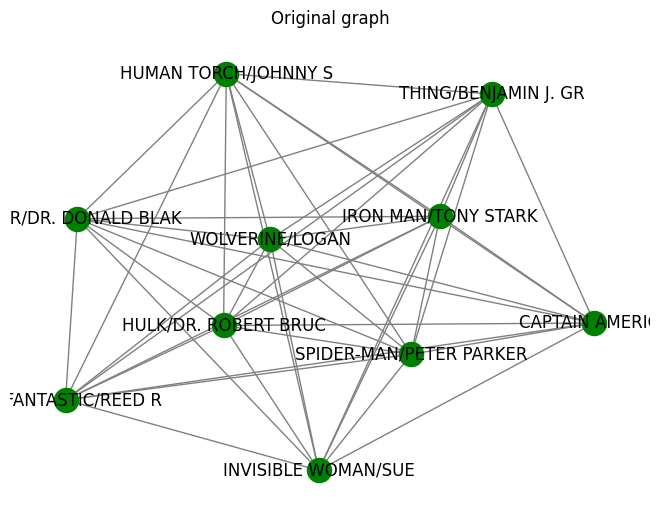

In [ ]:
# plotting the orginal graph
plt.clf()
nx.draw(subG, edge_color = 'grey', node_color = 'green', with_labels = True)
plt.title('Original graph')
plt.show()

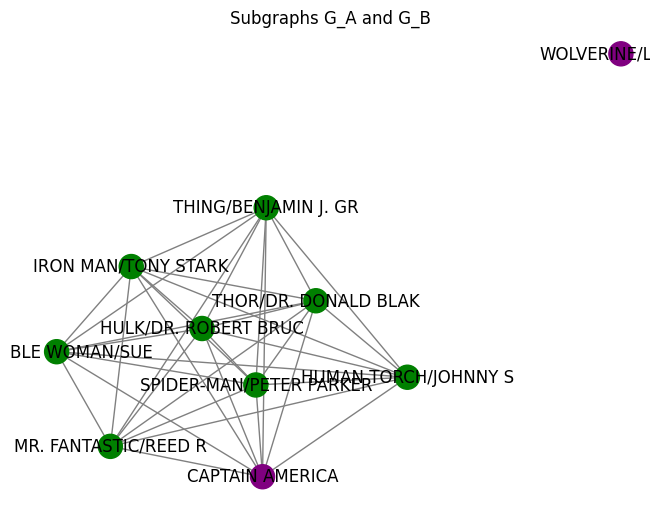

In [ ]:
reduced_subG = nx.Graph(subG)
reduced_subG.remove_edges_from(list(min_edges))
plt.clf()
color_map = ['purple' if (node == heroA or node == heroB) else 'green' for node in subG]        
nx.draw(reduced_subG, node_color = color_map, edge_color = 'grey', with_labels = True)
plt.title('Subgraphs G_A and G_B')
plt.show()

Testing on the second graph

In [ ]:
heroA = 'CAPTAIN AMERICA'
heroB = 'SPIDER-MAN/PETER PARKER'
N = 2
min_num, min_edges, subG = functionality4(G_comic_net, heroA, heroB, N)

In [ ]:
print('The minimum number of links that should be disconnected is', min_num)

The minimum number of links that should be disconnected is 334


DIREI CHE NON SI PUO' PLOTTARE

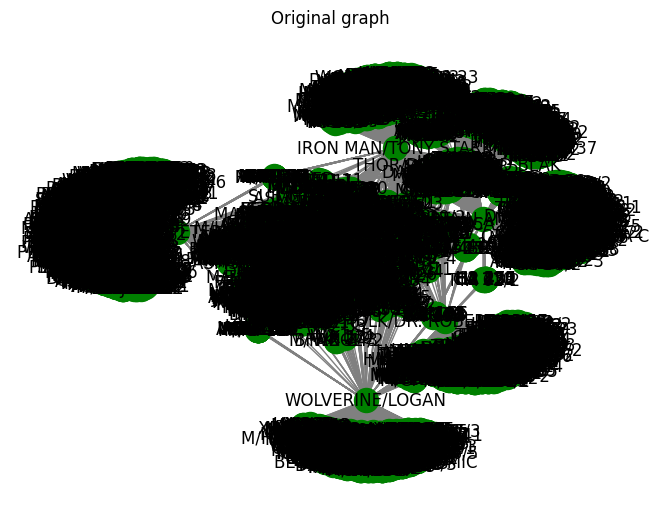

In [ ]:
# plotting the orginal graph
plt.clf()
nx.draw(subG, edge_color = 'grey', node_color = 'green', with_labels = True)
plt.title('Original graph')
plt.show()

##  Functionality 5 - Extracting Communities

In [25]:
def functionality5(G, N, hero1, hero2):
    # get the top N superHeroes 
    topN = edges.groupby('hero').count().sort_values(by = 'comic', ascending = False).head(N)
    topN = topN.reset_index()
    sub_graph = G.subgraph(list(topN['hero']))

    output={} # initialize the dict of outputs

    # we use min_num for saving the minimum number of cuts
    min_num = 0
    
    subG = nx.Graph(sub_graph)

    # while our graph is connected
    while nx.is_connected(subG):

        # we compute the edge betweenness centrality that returns a dictionary
        ebg = nx.edge_betweenness_centrality(subG)
        # we take the maximum of values
        max_ebg = max(ebg.values())

        # we save all edges to be cut that are the ones that have maximum egb
        edges_to_remove = [key for key in ebg.keys() if ebg[key] == max_ebg]

        # update min_num
        min_num += len(edges_to_remove)

        # we remove the edges
        subG.remove_edges_from(edges_to_remove)

    communities = [] # initialize the list of communities
    together = False # we start with False as initialization value
    
    for community in nx.connected_components(subG):
        # we append to communities the list
        communities.append(list(community))
        # only if hero1 and hero2 are in the same community we set together = True
        if (hero1 in community) and (hero2 in community):
            together = True
    
    # we store all the requested values in our dictionary
    output['Minimum number of edges']= min_num
    output['hero1 and hero2 together']= together
    output['list of communities']= communities
    
    return output, sub_graph, subG

## Visualization 5 - Visualize the communities

In [125]:
def searchCommunity(d,value):
      # given a dictionary ( in the form of a list of lists) and a value that function will output the key  
      for key, values in d.items():
       for v in values:
        if v == value:
            community_found = key
            break
      return community_found
            

In [128]:
def visualization5(G, N, hero1, hero2):
  
  # First, we call the function
  results, sub_graph, subG =functionality5(G, N, hero1, hero2)


  ################ Print the number of links that should be removed to have the communities ##############################

  # we use only the first results of our function
  print(f"The minimum number of edges that should be removed to form communities is", results['Minimum number of edges'])
  print(' ')

  #################### A table depicting the communities and the heroes that belong to each community ####################
 
  communities=len(results['list of communities']) # get the number of communities
  print(f"There are", communities,"communities in the network:")
  
  # we want a list of lists in which there are the identifiers of community and the nodes that belong to it:

  elements=[] # initialize the list
  for i in range(0,communities):
   string_ = str('Community ')+str(i) # create the string with the name of the community
   comm=results['list of communities'][i] # extract the community from the results of our function5
   elements.append([string_, comm]) # create the list of lists

  table_ = tabulate(elements, headers=["Communities", "hero"], tablefmt="fancy_grid") # we use the 'elements' list to create the table
  print(table_)
  print(' ')



  #################### Plot the original graph ####################


  print('The Original graph:')
  print(' ')

  plt.figure(figsize=(15, 10))
  plt.clf()
  plt.title('Original graph')
  pos= nx.spring_layout(sub_graph) # we use the spring_layout to better represent our graph
  nx.draw(sub_graph,pos, edge_color = 'moccasin', node_color = 'royalblue', with_labels = True, font_size=7)

  plt.show()
  print(' ')

  #################### Plot the graph showing the communities in the network ####################
  


  #################### Plot the final graph and identify the community/communities of Hero_1 and Hero_2 ####################
  print('The Final graph:')
  print(' ')
  plt.figure(figsize=(15, 10))
  plt.clf()
  plt.title('Final graph')
  color_map = ['tomato' if (node == hero1 or node == hero2) else 'green' for node in subG]
  pos= nx.spring_layout(subG) # we use the spring_layout to better represent our graph
  nx.draw(subG,pos, edge_color = 'moccasin', node_color = color_map , with_labels = True, font_size=7)

  plt.show()
  print(' ')

  e=dict(elements) # create a dict form the previous list of lists 'elements'

  if results['hero1 and hero2 together'] == True:

    #search the community
    community_found = searchCommunity(e,hero1)

    print(f"The heroes", hero1, " and ", hero2,"are in the same community: ", community_found)

  else:
    # find the communities for both 
    community_found1 = searchCommunity(e,hero1)
    community_found2 = searchCommunity(e,hero2)

    print(f"The heroes", hero1, " and ", hero2,"are not in the same community: ")
    print( hero1," is in ",community_found1 ," and ", hero2," is in ",community_found2)




The minimum number of edges that should be removed to form communities is 42
 
There are 2 communities in the network:
╒═══════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

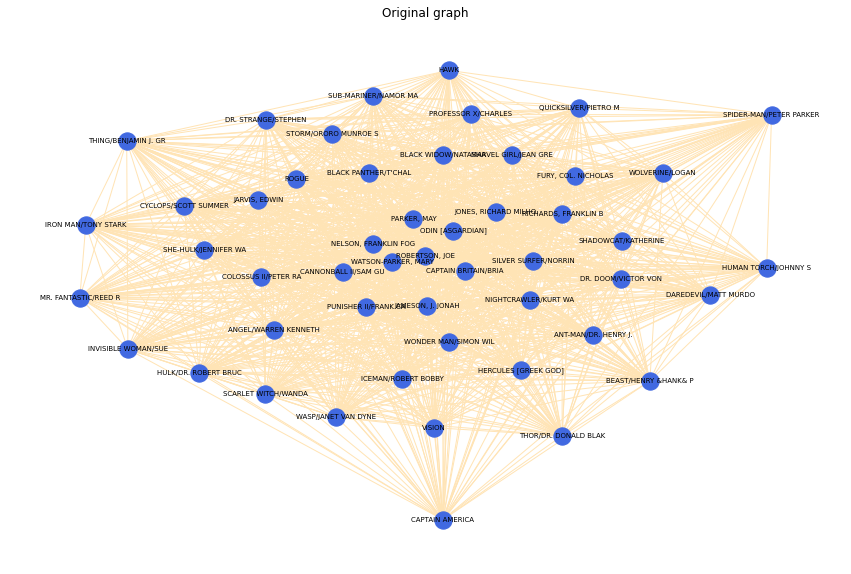

 
The Final graph:
 


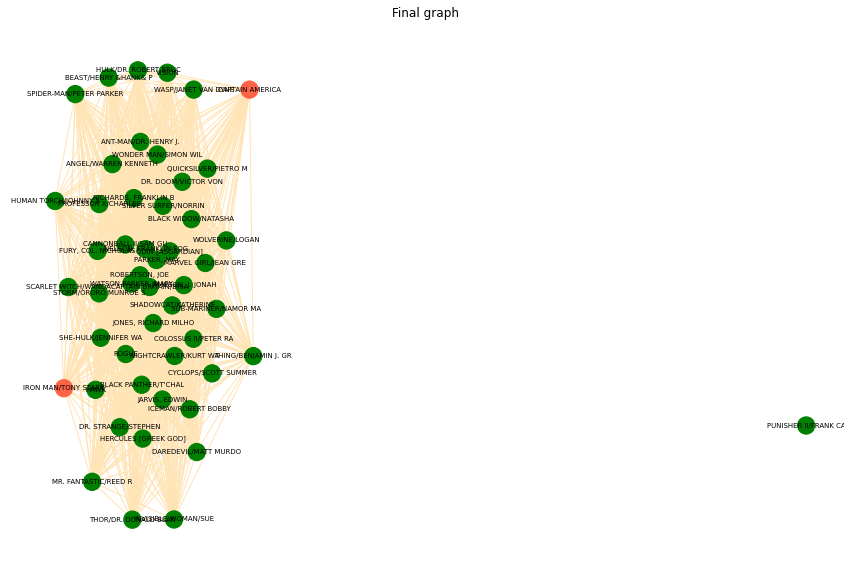

 
The heroes CAPTAIN AMERICA  and  IRON MAN/TONY STARK are in the same community:  Community 0


In [129]:
visualization5(G_hero_net, 50, 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK')